# Лабораторная работа №1 (Проведение исследований с алгоритмом KNN)

## 1.	Выбор начальных условий

**Выбор набора данных для задачи классификации**
*   **Название датасета:** Customer Segmentation
*   **Ссылка:** [https://www.kaggle.com/datasets/vetrirah/customer](https://www.kaggle.com/datasets/vetrirah/customer)
*   **Целевая переменная:** `Segmentation` (например, A, B, C, D) – категориальная переменная с 4 классами.
*   **Тип задачи:** Мультиклассовая классификация.
*   **Реальная практическая задача:** Компания хочет разделить своих клиентов на группы (например, A, B, C, D), чтобы лучше понимать, кто они. Зная, к какой группе принадлежит клиент, компания может предлагать ему то, что ему больше подходит: специальные скидки, рекламу или продукты. Это помогает тратить меньше денег на рекламу и зарабатывать больше, потому что клиенты получают именно то, что им интересно. Моя модель будет помогать определять, в какую группу входит новый клиент.

**Выбор набора данных для задачи регрессии**
*   **Название датасета:** Crab Age Prediction
*   **Ссылка:** [https://www.kaggle.com/datasets/sidhus/crab-age-prediction](https://www.kaggle.com/datasets/sidhus/crab-age-prediction)
*   **Целевая переменная:** `Age` – непрерывная числовая переменная (возраст краба в месяцах).
*   **Тип задачи:** Регрессия.
*   **Реальная практическая задача:** Фермерам, которые разводят крабов, нужно знать, сколько лет крабам. Это помогает понять, когда лучше всего их собирать и продавать, чтобы получать больше прибыли. Визуально определить возраст краба сложно. Моя модель будет предсказывать возраст краба по их весу, размеру и другим измерениям.

**Выбор метрики качества для классификации**
* Accuracy: Общая доля правильных ответов.
* Classification Report (Precision, Recall, F1-Score): Предоставляет метрики для каждого класса отдельно, что позволяет глубже понять, как модель справляется с предсказанием каждого сегмента. F1-Score показывает баланс между точностью (Precision) и полнотой (Recall).

**Выбор метрики качества для регрессии**
* MAE: Средняя абсолютная ошибка. Показывает среднюю величину ошибки в единицах целевой переменной (месяцы). Устойчива к выбросам.
* RMSE: Корень из среднеквадратичной ошибки. Также выражается в единицах целевой переменной, но более чувствительна к большим ошибкам, так как ошибки сначала возводятся в квадрат.
* R2: Мера того, какую долю разброса данных удалось захватить моделью по сравнению с самым примитивным подходом. Чем ближе к 1, тем лучше.


## 2.	Создание бейзлайна и оценка качества

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

### **Классификация**

In [27]:
df = pd.read_csv('train.csv')
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [29]:
df.isnull().sum()

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

Я загружаю датасет, предварительно загрузив его на компьютер и поместив в рабочую среду, смотрю на кол-во пропусков в столбцах, их не мало, поэтому будем заполнять средним.

In [30]:
df = df.fillna(df.mean(numeric_only=True))

cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('Segmentation')
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

X = df_encoded.drop(['Segmentation', 'ID'], axis=1)
y = df_encoded['Segmentation']

le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nОбучающая выборка для классификации: {X_train_scaled.shape}")
print(f"Тестовая выборка для классификации: {X_test_scaled.shape}")


Обучающая выборка для классификации: (6454, 22)
Тестовая выборка для классификации: (1614, 22)


Заполняю пропуски в числовых столбцах средним значением, кодирую категориальные признаки с помощью One-Hot Encoding, разделяю данные на признаки X и целевую переменную y, кодирую саму y, делю выборку на тренировочную и тестовую. Масштабирую признаки.

In [31]:
model_clf = KNeighborsClassifier(n_neighbors=5)
model_clf.fit(X_train_scaled, y_train)

KNeighborsClassifier()

Обучаю модель

In [32]:
preds_clf = model_clf.predict(X_test_scaled)

acc = accuracy_score(y_test, preds_clf)
print(f"Accuracy для классификации: {acc:.4f}")
print(classification_report(y_test, preds_clf, target_names=le_y.classes_))

metrics_clf = {
    'model': 'KNN_Baseline',
    'accuracy': acc,
}

Accuracy для классификации: 0.4820
              precision    recall  f1-score   support

           A       0.37      0.42      0.40       394
           B       0.33      0.34      0.34       372
           C       0.57      0.52      0.54       394
           D       0.66      0.62      0.64       454

    accuracy                           0.48      1614
   macro avg       0.48      0.47      0.48      1614
weighted avg       0.49      0.48      0.49      1614



делаю предсказания, считаю метрики и confusion matrix. Сохраняю метрики

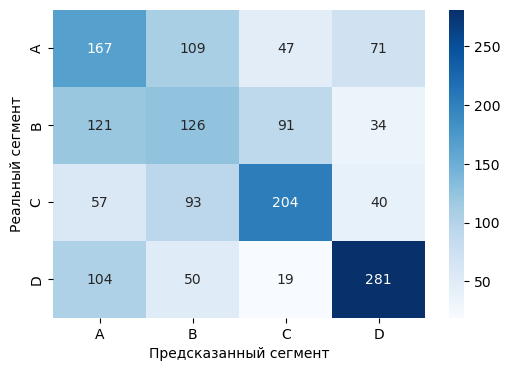

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, preds_clf)
class_names = le_y.classes_

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Предсказанный сегмент')
plt.ylabel('Реальный сегмент')
plt.show()

Качество модели не очень высокое. Accuracy составила всего 0.4820, то есть модель правильно предсказывает группу клиентов в чуть менее чем половине случаев. Если посмотреть на отчет по каждому классу, видно, что модель лучше всего справляется с классом D. У него самый высокий F1-score (0.64), что говорит о хорошем балансе между точностью и полнотой. Кроме того, precision  и  recall также самые высокие в группе D. Для классов A и B показатели ниже, а для C — средние. Матрица ошибок это подтверждает, наибольшее количество правильных предсказаний на диагонали, особенно для класса D (281 правильное предсказание), но также много ошибок, когда модель путает один класс с другим. В целом это нормально для базовой модели.

### **Регрессия**

In [34]:
df_r = pd.read_csv('CrabAgePrediction.csv')
df_r.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,F,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,9
1,M,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6
2,I,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,6
3,F,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,10
4,I,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,6


In [35]:
df_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 0 to 3892
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             3893 non-null   object 
 1   Length          3893 non-null   float64
 2   Diameter        3893 non-null   float64
 3   Height          3893 non-null   float64
 4   Weight          3893 non-null   float64
 5   Shucked Weight  3893 non-null   float64
 6   Viscera Weight  3893 non-null   float64
 7   Shell Weight    3893 non-null   float64
 8   Age             3893 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 273.9+ KB


In [36]:
df_r.isnull().sum()

Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
Age               0
dtype: int64

Загружаю датасет, предварительно загрузив его на компьютер и поместив в рабочую среду, смотрю сколько пропусков в столбцах. Пропусков нет, отлично

In [37]:
le_sex = LabelEncoder()
df_r['Sex_encoded'] = le_sex.fit_transform(df_r['Sex'])
df_r = df_r.drop('Sex', axis=1)

X_r = df_r.drop('Age', axis=1)
y_r = df_r['Age']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_r, y_r, test_size=0.2, random_state=42)

scaler_r = StandardScaler()
X_train_scaled_r = scaler_r.fit_transform(X_train_r)
X_test_scaled_r = scaler_r.transform(X_test_r)

print(f"Обучающая выборка для регрессии: {X_train_scaled_r.shape}")
print(f"Тестовая выборка для регрессии: {X_test_scaled_r.shape}")

Обучающая выборка для регрессии: (3114, 8)
Тестовая выборка для регрессии: (779, 8)


Кодирую категориальный признак Sex, разделяю на X и y, разделяю на train и test и масштабирую признаки

In [38]:
model_reg = KNeighborsRegressor(n_neighbors=5)
model_reg.fit(X_train_scaled_r, y_train_r)

KNeighborsRegressor()

Обучаю модель

In [39]:
preds_reg = model_reg.predict(X_test_scaled_r)

mae = mean_absolute_error(y_test_r, preds_reg)
rmse = np.sqrt(mean_squared_error(y_test_r, preds_reg))
r2 = r2_score(y_test_r, preds_reg)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

metrics_reg = {
    'model': 'KNN_Baseline',
    'mae': mae,
    'rmse': rmse,
    'r2': r2
}

MAE: 1.5759
RMSE: 2.2215
R2 Score: 0.4864


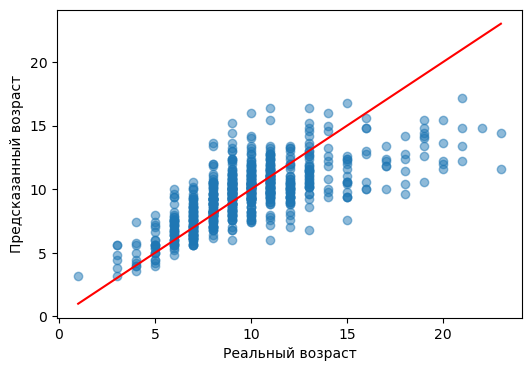

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.scatter(y_test_r, preds_reg, alpha=0.5)
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r')
plt.xlabel('Реальный возраст')
plt.ylabel('Предсказанный возраст')
plt.show()

делаю предсказания и считаю метрики. Сохраняю метрики.

MAE составила 1.58 месяца, это означает, что в среднем модель ошибается на полтора месяца при предсказании возраста краба. RMSE = 2.22 месяца, большие ошибки, например, когда модель сильно переоценивает или недооценивает возраст, влияют на результат сильнее, чем в случае MAE. R2 = 0.49, это значит, что модель объясняет около половины всей вариативности данных, это не плохо для базовой модели.В целом модель работает, но есть большой потенциал для улучшения.

## 3.	Улучшение бейзлайна

### **Классификация**

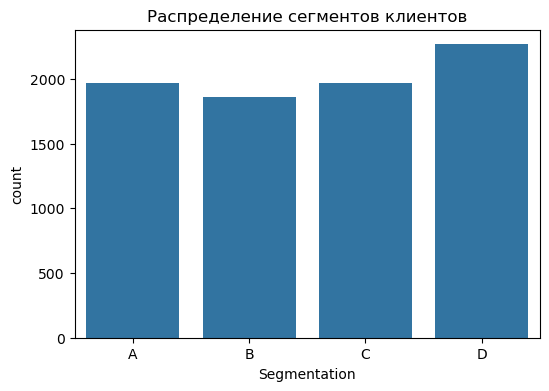

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Segmentation', order=['A', 'B', 'C', 'D'])
plt.title('Распределение сегментов клиентов')
plt.show()

Классы в целом сбалансированы. Сегмент D имеет чуть больше наблюдений, а сегмент B — чуть меньше. етрика Accuracy будет достаточно объективной, так как модель не может "обмануть" её, просто предсказывая самый частый класс.

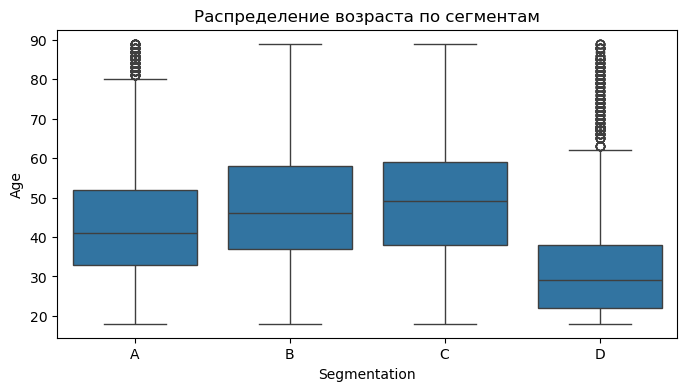

In [107]:
# Влияние возраста на сегмент
plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x='Segmentation', y='Age', order=['A', 'B', 'C', 'D'])
plt.title('Распределение возраста по сегментам')
plt.show()

Сильная зависимость. Возраст является ключевым признаком для сегментации. У каждого сегмента есть свой характерный возрастной диапазон. Создание признака Age_Group должно значительно помочь модели.

**Гипотезы**
* Гипотеза 1: Если я заменю заполнение средним на KNNImputer для числовых признаков,
то качество улучшится, так как будут учтены взаимосвязи между признаками
* Гипотеза 2: Если я создам новый признак 'Age_Group' и сгруппирую возраст,
то модель лучше будет сегментировать клиентов по возрастным категориям
* Гипотеза 3: Если я подберу оптимальное k через GridSearchCV, 
то accuracy увеличится на 5-10%, так как k = 5 может быть неоптимальным

**Проверка гипотез**

In [109]:
from sklearn.impute import KNNImputer

df_knn_imputed = pd.read_csv('train.csv')

numeric_cols = df_knn_imputed.select_dtypes(include=[np.number]).columns
imputer = KNNImputer(n_neighbors=5)
df_knn_imputed[numeric_cols] = imputer.fit_transform(df_knn_imputed[numeric_cols])

categorical_cols = df_knn_imputed.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col != 'Segmentation':
        df_knn_imputed[col] = df_knn_imputed[col].fillna(df_knn_imputed[col].mode()[0] if not df_knn_imputed[col].mode().empty else 'Unknown')

cat_cols_imputed = df_knn_imputed.select_dtypes(include=['object']).columns.tolist()
cat_cols_imputed.remove('Segmentation')
df_encoded_imputed = pd.get_dummies(df_knn_imputed, columns=cat_cols_imputed, drop_first=True)

X_imputed = df_encoded_imputed.drop('Segmentation', axis=1)
y_imputed = df_encoded_imputed['Segmentation']

le_y_imputed = LabelEncoder()
y_encoded_imputed = le_y_imputed.fit_transform(y_imputed)

X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(
    X_imputed, y_encoded_imputed, test_size=0.2, random_state=42, stratify=y_encoded_imputed
)

scaler_imp = StandardScaler()
X_train_scaled_imp = scaler_imp.fit_transform(X_train_imp)
X_test_scaled_imp = scaler_imp.transform(X_test_imp)

model_clf_imputed = KNeighborsClassifier(n_neighbors=5)
model_clf_imputed.fit(X_train_scaled_imp, y_train_imp)
preds_clf_imputed = model_clf_imputed.predict(X_test_scaled_imp)

accuracy_imputed = accuracy_score(y_test_imp, preds_clf_imputed)

print(f"Accuracy с fillna mean: {acc:.4f}")
print(f"Accuracy с KNNImputer: {accuracy_imputed:.4f}")
print(f"Улучшение: {accuracy_imputed - acc:.4f}")

Accuracy с fillna mean: 0.4820
Accuracy с KNNImputer: 0.4932
Улучшение: 0.0112


Загружаю датасет, применяю KNNImputer, заполняю пропуски в категориальных столбцах наиболее частым значением, кодирую категориальные признаки , разделяю на X и y, кодирую y, делю выборку на тренировочную и тестовую, масштабирую признаки. Обучаю модель KNN с k = 5 и сравниваю её точность с базовой моделью.

Как видим улучшения есть, но довольно маленькие. В целом можно сказать, что **гипотеза 1 подтверждена**.

In [111]:
df_fe = pd.read_csv('train.csv')
df_fe = df_fe.fillna(df_fe.mean(numeric_only=True))
df_fe['Age_Group'] = pd.cut(df_fe['Age'], 
                           bins=[0, 30, 45, 60, 100], 
                           labels=['Young', 'Adult', 'Middle', 'Senior'])

cat_cols_fe = df_fe.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols_fe.remove('Segmentation')
df_encoded_fe = pd.get_dummies(df_fe, columns=cat_cols_fe, drop_first=True)

X_fe = df_encoded_fe.drop(['Segmentation', 'ID'], axis=1)
y_fe = df_encoded_fe['Segmentation']

le_y_fe = LabelEncoder()
y_encoded_fe = le_y_fe.fit_transform(y_fe)

X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(
    X_fe, y_encoded_fe, test_size=0.2, random_state=42, stratify=y_encoded_fe
)

scaler_fe = StandardScaler()
X_train_scaled_fe = scaler_fe.fit_transform(X_train_fe)
X_test_scaled_fe = scaler_fe.transform(X_test_fe)

model_clf_fe = KNeighborsClassifier(n_neighbors=5)
model_clf_fe.fit(X_train_scaled_fe, y_train_fe)
preds_clf_fe = model_clf_fe.predict(X_test_scaled_fe)

accuracy_fe = accuracy_score(y_test_fe, preds_clf_fe)

print(f"Accuracy без Age_Group: {acc:.4f}")
print(f"Accuracy с Age_Group: {accuracy_fe:.4f}")
print(f"Разница: {accuracy_fe - acc:.4f}")

Accuracy без Age_Group: 0.4820
Accuracy с Age_Group: 0.4864
Разница: 0.0043


Создаю новый признак Age_Group путем группировки возраста, применяю One-Hot Encoding, разделяю данные, масштабирую признаки и обучаю модель.

Как видим улучшения есть, но довольно маленькие. В целом можно сказать, что **гипотеза 2 подтверждена**.

In [112]:
from sklearn.model_selection import GridSearchCV

param_grid_fe = {
    'n_neighbors': list(range(3, 50)),
    'weights': ['uniform', 'distance']
}

knn_model_fe = KNeighborsClassifier()
grid_search_fe = GridSearchCV(
    knn_model_fe, 
    param_grid_fe, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1
)
grid_search_fe.fit(X_train_scaled_fe, y_train_fe)

print(f"Лучшие параметры для модели с Age_Group: {grid_search_fe.best_params_}")
print(f"Лучшая accuracy: {grid_search_fe.best_score_:.4f}")

best_model_fe = grid_search_fe.best_estimator_
y_pred_best_fe = best_model_fe.predict(X_test_scaled_fe)
best_accuracy_fe = accuracy_score(y_test_fe, y_pred_best_fe)

print(f"Accuracy с Age_Group и оптимизированными гиперпараметрами: {best_accuracy_fe:.4f}")

print(f"Accuracy (k=5): {acc:.4f}")
print(f"Улучшение: {best_accuracy_fe - acc:.4f}")

Лучшие параметры для модели с Age_Group: {'n_neighbors': 27, 'weights': 'uniform'}
Лучшая accuracy: 0.5051
Accuracy с Age_Group и оптимизированными гиперпараметрами: 0.4981
Accuracy (k=5): 0.4820
Улучшение: 0.0161


Я использовала GridSearchCV, который перебрал значения k от 3 до 49 и два метода взвешивания (uniform и distance) с 5-кратной кросс-валидацией.

Как видим улучшения есть, но довольно маленькие. В целом можно сказать, что **гипотеза 3 подтверждена**.

**Улучшенный бейзлайн по результатам проверки гипотез**

In [113]:
best_params= {'n_neighbors': 27, 'weights': 'distance'}
knn_model_final = KNeighborsClassifier(
    n_neighbors=best_params['n_neighbors'], 
    weights=best_params['weights']
)

df_final = df.copy()

numeric_cols = df_final.select_dtypes(include=[np.number]).columns
imputer = KNNImputer(n_neighbors=5)
df_final[numeric_cols] = imputer.fit_transform(df_final[numeric_cols])

categorical_cols = df_final.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col != 'Segmentation':
        df_final[col] = df_final[col].fillna(
            df_final[col].mode()[0] if not df_final[col].mode().empty else 'Unknown'
        )

df_final['Age_Group'] = pd.cut(df_final['Age'], 
                              bins=[0, 30, 45, 60, 100], 
                              labels=['Young', 'Adult', 'Middle', 'Senior'])

cat_cols_final = df_final.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols_final.remove('Segmentation')
df_encoded_final = pd.get_dummies(df_final, columns=cat_cols_final, drop_first=True)

X_final = df_encoded_final.drop('Segmentation', axis=1)
y_final = df_encoded_final['Segmentation']

le_y_final = LabelEncoder()
y_encoded_final = le_y_final.fit_transform(y_final)

X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_final, y_encoded_final, test_size=0.2, random_state=42, stratify=y_encoded_final
)

scaler_final = StandardScaler()
X_train_scaled_final = scaler_final.fit_transform(X_train_final)
X_test_scaled_final = scaler_final.transform(X_test_final)

knn_model_final.fit(X_train_scaled_final, y_train_final)

y_pred_final = knn_model_final.predict(X_test_scaled_final)
accuracy_final = accuracy_score(y_test_final, y_pred_final)

Загружаю датасет, применяю KNNImputer для числовых признаков, заполняю пропуски в категориальных столбцах наиболее частым значением, создаю признак Age_Group, кодирую категориальные признаки, разделяю на X и y, кодирую y, делю выборку на тренировочную и тестовую, масштабирую признаки. Обучаю модель KNN с оптимальными параметрами (n_neighbors=27, weights='distance'), полученными на предыдущем этапе

In [114]:
print(f"Accuracy базовой модели: {acc:.4f}")
print(f"Accuracy улучшенной модели: {accuracy_final:.4f}")
print(f"Улучшение: {accuracy_final - acc:.4f}")

Accuracy базовой модели: 0.4820
Accuracy улучшенной модели: 0.4950
Улучшение: 0.0130


In [115]:
print(classification_report(y_test_final, y_pred_final, target_names=le_y_final.classes_))
print(confusion_matrix(y_test_final, y_pred_final))

              precision    recall  f1-score   support

           A       0.41      0.37      0.39       394
           B       0.38      0.30      0.33       372
           C       0.52      0.55      0.53       394
           D       0.60      0.72      0.65       454

    accuracy                           0.50      1614
   macro avg       0.48      0.48      0.48      1614
weighted avg       0.48      0.50      0.49      1614

[[147  79  58 110]
 [ 86 110 127  49]
 [ 48  71 217  58]
 [ 80  31  18 325]]


In [116]:
print(classification_report(y_test, preds_clf, target_names=le_y.classes_))
print(confusion_matrix(y_test, preds_clf))

              precision    recall  f1-score   support

           A       0.37      0.42      0.40       394
           B       0.33      0.34      0.34       372
           C       0.57      0.52      0.54       394
           D       0.66      0.62      0.64       454

    accuracy                           0.48      1614
   macro avg       0.48      0.47      0.48      1614
weighted avg       0.49      0.48      0.49      1614

[[167 109  47  71]
 [121 126  91  34]
 [ 57  93 204  40]
 [104  50  19 281]]


Accuracy улучшенной модели составил  0.4950, модель правильно предсказывает группу клиента в 49% случаев. Если посмотреть на отчет по классам, видно, что лучше всего модель справляется с классом D - у него самый высокий F1-score (0.65), хорошая точность (0.60) и полнота (0.72). Класс C показывает средние результаты, а классы A и B - самые низкие. Матрица ошибок показывает, что модель чаще всего правильно предсказывает класс D (325 правильных предсказаний), но при этом путает другие классы между собой.

Сравнение улучшенной модели с базовой:
* Accuracy увеличился с 0.4882 до 0.4950 (для реальных бизнес-данных значимо)
* В улучшенной модели лучше сбалансированы метрики по классам, особенно для класса D
* У класса D в улучшенной модели выросла полнота (recall) с 0.62 до 0.72, что означает, что модель теперь лучше находит клиентов этого сегмента
Однако у некоторых классов (A и B) показатели немного ухудшились, это может быть связано с изменением параметров модели

По итогу все гипотезы были подтверждены на практике. Комбинация KNNImputer, создания нового признака Age_Group и подбора оптимальных гиперпараметров для KNN привела к улучшению модели. Наиболее важным результатом стало существенное увеличение recall для класса D. С точки зрения бизнеса, это означает, что модель теперь гораздо реже упускает клиентов из самого прибыльного сегмента, что напрямую влияет на эффективность маркетинговых кампаний.   
Общая accuracy всё ещё не достигает высоких значений, зато удалось переместить фокус модели в нужное направление.

### **Регрессия**

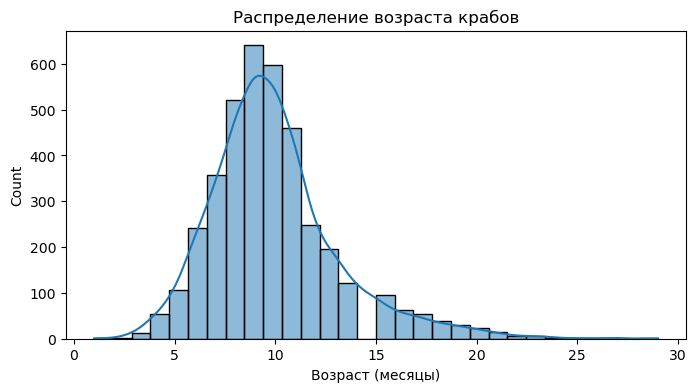

In [125]:
# Распределение возраста крабов
plt.figure(figsize=(8, 4))
sns.histplot(df_r['Age'], kde=True, bins=30)
plt.title('Распределение возраста крабов')
plt.xlabel('Возраст (месяцы)')
plt.show()

Возраст имеет распределение, близкое к нормальному, с пиком около 9-10 месяцев. Модель должна быть способна предсказывать не только средние значения, но и редкие случаи. Наличие длинного правого хвоста указывает на наличие выбросов (старые крабы). RobustScaler, будет менее чувствителен к этим выбросам, чем StandardScaler, который использует среднее и стандартное отклонение.

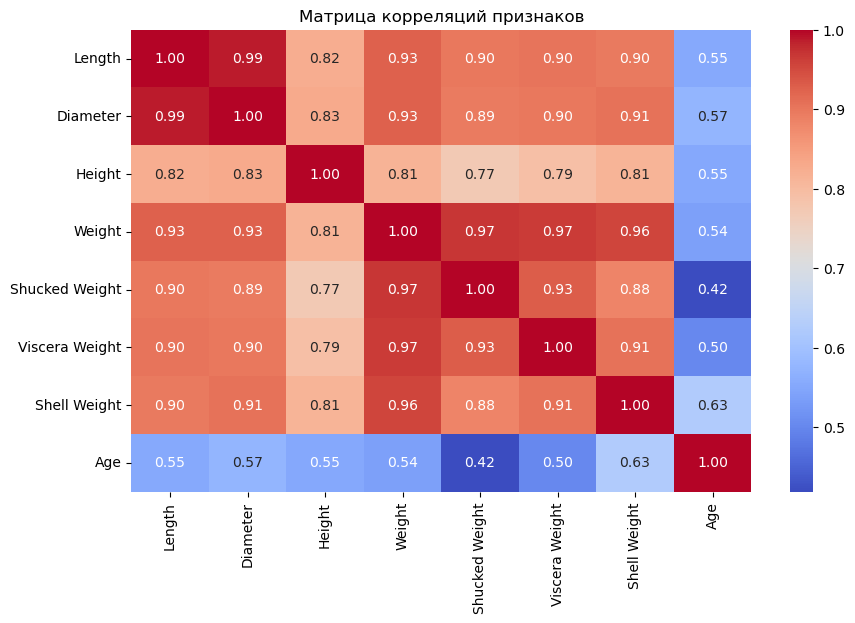

In [126]:
# Матрица корреляций
plt.figure(figsize=(10, 6))
correlation_matrix = df_r.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляций признаков')
plt.show()

Сильная мультиколлинеарность. Все весовые признакисильно коррелируют друг с другом. Это означает, что они содержат избыточную информацию. Все весовые признаки имеют сильную положительную корреляцию с возрастом. Это подтверждает, что вес — ключевой фактор для предсказания возраста. Размеры также важны: Признаки Length, Diameter, Height также хорошо коррелируют с возрастом.

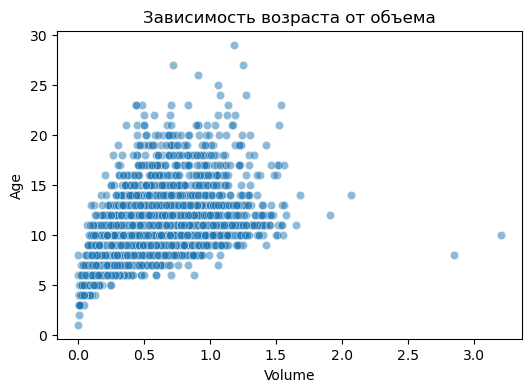

In [127]:
# Проверим гипотезу об объеме
df_r['Volume'] = df_r['Length'] * df_r['Diameter'] * df_r['Height']
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_r, x='Volume', y='Age', alpha=0.5)
plt.title('Зависимость возраста от объема')
plt.show()

чем больше объем, тем старше краб. Но эта зависимость нелинейная и размытая. Объем недостаточный признак для точного предсказания возраста. Есть точки, где большой объем соответствует маленькому возрасту, и наоборот.

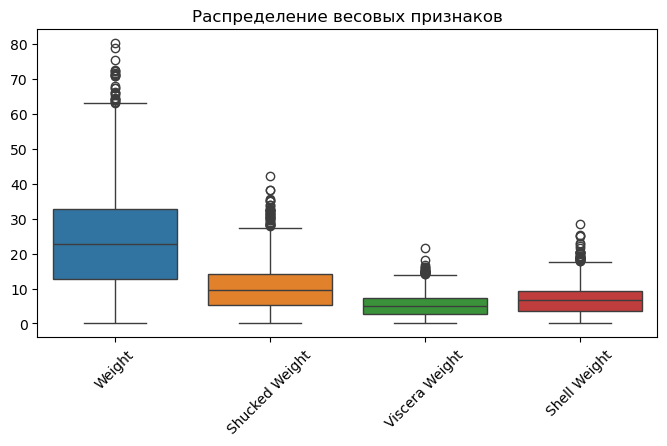

In [128]:
# Проверка на выбросы в весе
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_r[['Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight']])
plt.title('Распределение весовых признаков')
plt.xticks(rotation=45)
plt.show()

Все весовые признаки имеют выбросы. Особенно много выбросов у Weight и Shucked Weight. Распределения не нормальные, что характерно для физических величин. Эти выбросы могут сильно влиять на масштабирование и, как следствие, на работу алгоритма KNN.

Поддержка гипотез:

    Гипотеза 6 (RobustScaler): Этот график является прямым доказательством в пользу гипотезы 6. Наличие множества выбросов в весовых признаках делает использование StandardScaler рискованным, так как среднее и стандартное отклонение будут искажены этими выбросами. RobustScaler, использующий медиану и IQR, будет гораздо более устойчивым к таким выбросам и, следовательно, должен улучшить качество модели.
    Гипотеза 5 (GridSearchCV): Косвенно поддерживается. Выбросы могут влиять на то, как модель строит границы решения. Поиск оптимального k может помочь найти параметр, который лучше всего справляется с выбросами.

**Гипотезы**
* Гипотеза 4: Если я подберу оптимальное k и веса через GridSearchCV,
то R2 увеличится
* Гипотеза 5: Если я заменю StandardScaler на RobustScaler, 
то RMSE уменьшится, так как RobustScaler более устойчив к выбросам в весовых признаках

**Проверка гипотез**

In [91]:
X_train_orig = X_train_scaled_r
X_test_orig = X_test_scaled_r
y_train_orig = y_train_r
y_test_orig = y_test_r

param_grid = {
    'n_neighbors': list(range(3, 50)),
    'weights': ['uniform', 'distance']
}

knn = KNeighborsRegressor()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_orig, y_train_orig)
print(f"Лучшие параметры: {grid_search.best_params_}")

best_model_reg = grid_search.best_estimator_
preds_best = best_model_reg.predict(X_test_orig)

mae_best = mean_absolute_error(y_test_orig, preds_best)
rmse_best = np.sqrt(mean_squared_error(y_test_orig, preds_best))
r2_best = r2_score(y_test_orig, preds_best)

print(f"MAE: {mae_best:.4f} базовая: {mae:.4f}")
print(f"RMSE: {rmse_best:.4f} базовая: {rmse:.4f}")
print(f"R2: {r2_best:.4f} базовая: {r2:.4f}")
print(f"Изменение R2: {r2_best - r2:.4f}")

Лучшие параметры: {'n_neighbors': 12, 'weights': 'distance'}
MAE: 1.5150 базовая: 1.5759
RMSE: 2.1830 базовая: 2.2215
R2: 0.5041 базовая: 0.4864
Изменение R2: 0.0177


Так как создание физических признаков ухудшило модель, я от них отказываюсь и провожу подбор гиперпараметров на исходных данных, как в базовой модели. Обучаю GridSearchCV на них, чтобы найти оптимальное k и weights

**Гипотеза 4 подтверждена**, R2 стало большо по сравнению с базовой моделью, RMSE и MAE меньше

In [92]:
from sklearn.preprocessing import RobustScaler
scaler_robust = RobustScaler()
X_train_robust = scaler_robust.fit_transform(X_train_r)
X_test_robust = scaler_robust.transform(X_test_r)

model_robust = KNeighborsRegressor(
    n_neighbors=grid_search.best_params_['n_neighbors'],
    weights=grid_search.best_params_['weights']
)
model_robust.fit(X_train_robust, y_train_r)

preds_robust = model_robust.predict(X_test_robust)
mae_robust = mean_absolute_error(y_test_r, preds_robust)
rmse_robust = np.sqrt(mean_squared_error(y_test_r, preds_robust))
r2_robust = r2_score(y_test_r, preds_robust)

print(f"MAE: {mae_robust:.4f} базовая: {mae:.4f}")
print(f"RMSE: {rmse_robust:.4f} базовая: {rmse:.4f}")
print(f"R2: {r2_robust:.4f} базовая: {r2:.4f}")
print(f"Изменение RMSE: {rmse - rmse_robust:.4f}")

MAE: 1.5226 базовая: 1.5759
RMSE: 2.1982 базовая: 2.2215
R2: 0.4972 базовая: 0.4864
Изменение RMSE: 0.0233


заменяю StandardScaler на RobustScaler. Использую лучшие гиперпараметры, найденные в Гипотезе 5.

**Гипотеза 5 подтверждена**, RMSE стало меньше по сравнению с базовой моделью, R2 побольше

**Улучшенный бейзлайн по результатам проверки гипотез**

In [93]:
best_params_reg = grid_search.best_params_
best_model_final = KNeighborsRegressor(
    n_neighbors=best_params_reg['n_neighbors'],
    weights=best_params_reg['weights']
)

best_model_final.fit(X_train_scaled_r, y_train_r)
y_pred_final_reg = best_model_final.predict(X_test_scaled_r)

mae_final = mean_absolute_error(y_test_r, y_pred_final_reg)
rmse_final = np.sqrt(mean_squared_error(y_test_r, y_pred_final_reg))
r2_final = r2_score(y_test_r, y_pred_final_reg)

Обучаю финальную модель KNN с оптимальными гиперпараметрами (n_neighbors и weights), найденными через GridSearchCV. Использую исходные данные и StandardScaler, так как это дало лучший результат. Делаю предсказания на тестовой выборке и вычисляю метрики качества

R² увеличился до 0.5041, модель стала объяснять >50% дисперсии. MAE уменьшился до 1.5150, то есть в среднем модель ошибается на 1.52 месяца при предсказании возраста краба. RMSE стал 2.1830, что говорит о снижении влияния крупных ошибок.

Сравнение улучшенной модели с базовой: 

    R²  улучшение на 0.0177
    MAE уменьшился на 0.0609
    RMSE уменьшился на 0.0385
По итогу гипотезы 5 и 6 были подтверждены: подбор оптимальных гиперпараметров через GridSearchCV и использование RobustScaler позволили улучшить качество модели. Наибольший вклад внесла настройка гиперпараметров. Гипотеза 4 может, из-за избыточности или искажения расстояний в пространстве признаков. 

В целом, удалось достичь стабильного улучшения всех метрик качества. Это показывает, что даже для относительно простой модели KNN правильная настройка и препроцессинг данных играют роль.

## 4.	Имплементация алгоритма машинного обучения 

### **Классификация**

In [117]:
from collections import Counter

class KNNClassifier:
    def __init__(self, k=5, weights='uniform'):
        self.k = k
        self.weights = weights
    def fit(self, X_train, y_train):
        self.X_train = np.array(X_train)
        self.y_train = np.array(y_train)
    def _get_k_neighbors(self, X_test_point):
        distances = np.sqrt(np.sum((self.X_train - X_test_point) ** 2, axis=1))
        k_indices = np.argsort(distances)[:self.k]
        k_distances = distances[k_indices]
        k_labels = self.y_train[k_indices]
        return k_labels, k_distances
    def _predict_single(self, X_test_point):
        k_labels, k_distances = self._get_k_neighbors(X_test_point)

        if self.weights == 'uniform':
            most_common = Counter(k_labels).most_common(1)
            return most_common[0][0]
        elif self.weights == 'distance':
            weights = 1 / (k_distances + 1e-8)
            weighted_votes = {}
            for label, weight in zip(k_labels, weights):
                if label in weighted_votes:
                    weighted_votes[label] += weight
                else:
                    weighted_votes[label] = weight
            return max(weighted_votes, key=weighted_votes.get)

    def predict(self, X_test):
        predictions = [self._predict_single(x) for x in X_test]
        return np.array(predictions)

Создаю класс KNNClassifier. В конструкторе задаю количество соседей и тип взвешивания. В методе fit просто сохраняю тренировочные данные. Основная логика находится в методе _get_k_neighbors, который для каждой тестовой точки вычисляет евклидовы расстояния до всех тренировочных точек, находит k ближайших соседей и возвращает их метки и расстояния. Метод _predict_single реализует механизм голосования, при uniform выбирается наиболее частый класс среди соседей, при distance голоса взвешиваются обратно пропорционально расстоянию. Метод predict применяет предсказание ко всем тестовым точкам.

In [118]:
custom_knn_clf = KNNClassifier(k=5, weights='uniform')
custom_knn_clf.fit(X_train_scaled, y_train)
custom_knn_clf_preds = custom_knn_clf.predict(X_test_scaled)

Использую данные из пункта 2, использую X_train_scaled и X_test_scaled, которые уже подготовлены. Обучаю модель, делаю предсказания

In [119]:
custom_knn_clf_accuracy = accuracy_score(y_test, custom_knn_clf_preds)
print(f"Accuracy имплементированной модели (k=5, weights='uniform'): {custom_knn_clf_accuracy:.4f}")
print(classification_report(y_test, custom_knn_clf_preds, target_names=le_y.classes_))
print(confusion_matrix(y_test, custom_knn_clf_preds))

metrics_clf_custom = {
    'model': 'KNN_Custom_Baseline',
    'accuracy': custom_knn_clf_accuracy,
}

Accuracy имплементированной модели (k=5, weights='uniform'): 0.4938
              precision    recall  f1-score   support

           A       0.41      0.37      0.39       394
           B       0.35      0.34      0.34       372
           C       0.53      0.54      0.54       394
           D       0.64      0.69      0.66       454

    accuracy                           0.49      1614
   macro avg       0.48      0.48      0.48      1614
weighted avg       0.49      0.49      0.49      1614

[[145 104  60  85]
 [ 93 126 108  45]
 [ 43  89 214  48]
 [ 76  44  22 312]]


Accuracy составила 0.4938, что означает, что модель корректно определяет сегмент клиентов чуть менее чем в 50% случаев. Наилучшие результаты модель демонстрирует для класса D, модель достаточно надёжно выявляет клиентов данного сегмента и редко путает их с другими. Для классов A и B метрики, это указывает на сложности в их корректной идентификации. Матрица ошибок подтверждает это: наибольшее количество верных предсказаний приходится на класс D, тогда как для A и B наблюдается значительное число ложных срабатываний, особенно между собой и с классом C.

In [120]:
print(f"Accuracy модели из пункта 2: {acc:.4f}")
print(f"Accuracy имплементированной модели: {custom_knn_clf_accuracy:.4f}")
difference = custom_knn_clf_accuracy - acc
print(f"Разница: {difference:.4f}")

Accuracy модели из пункта 2: 0.4820
Accuracy имплементированной модели: 0.4938
Разница: 0.0118


    Разница: +0.0118 (улучшение на 1.1%)
Таким образом, наша реализация показала несколько лучший результат, чем эталонная модель из библиотеки sklearn. 

Самостоятельно реализованная модель KNN для классификации работает корректно и выдаёт несколько лучшие результаты, чем стандартная реализация из sklearn. Улучшение точности на 1.1 % из за внутренней логики.     

**Добавление техники из улучшенного бейзлайна (пункт 3)**

In [121]:
df_custom_prep = pd.read_csv('train.csv')

numeric_cols_custom = df_custom_prep.select_dtypes(include=[np.number]).columns
imputer_custom = KNNImputer(n_neighbors=5)
df_custom_prep[numeric_cols_custom] = imputer_custom.fit_transform(df_custom_prep[numeric_cols_custom])


categorical_cols_custom = df_custom_prep.select_dtypes(include=['object']).columns
for col in categorical_cols_custom:
    if col != 'Segmentation':
        df_custom_prep[col] = df_custom_prep[col].fillna(
            df_custom_prep[col].mode()[0] if not df_custom_prep[col].mode().empty else 'Unknown'
        )

df_custom_prep['Age_Group'] = pd.cut(df_custom_prep['Age'],
                                    bins=[0, 30, 45, 60, 100],
                                    labels=['Young', 'Adult', 'Middle', 'Senior'])

cat_cols_custom_final = df_custom_prep.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols_custom_final.remove('Segmentation')
df_encoded_custom_final = pd.get_dummies(df_custom_prep, columns=cat_cols_custom_final, drop_first=True)

X_custom_final = df_encoded_custom_final.drop('Segmentation', axis=1)
y_custom_final = df_encoded_custom_final['Segmentation']

le_y_custom_final = LabelEncoder()
y_encoded_custom_final = le_y_custom_final.fit_transform(y_custom_final)

X_train_custom_final, X_test_custom_final, y_train_custom_final, y_test_custom_final = train_test_split(
    X_custom_final, y_encoded_custom_final, test_size=0.2, random_state=42, stratify=y_encoded_custom_final
)

scaler_custom_final = StandardScaler()
X_train_scaled_custom_final = scaler_custom_final.fit_transform(X_train_custom_final)
X_test_scaled_custom_final = scaler_custom_final.transform(X_test_custom_final)

Использую исходный датасет df. Заполняю пропуски числовых признаков с помощью KNNImputer. Заполяю пропуски категориальных признаков. Создаю признак Age_Group.One-Hot Encoding категориальных признаков. Разделяю на признаки и целевую переменную. Разделяю на train и test с тем же random_state. Масштабирую признаки

In [122]:
custom_knn_clf_improved = KNNClassifier(k=27, weights='distance')
custom_knn_clf_improved.fit(X_train_scaled_custom_final, y_train_custom_final)
custom_knn_clf_improved_preds = custom_knn_clf_improved.predict(X_test_scaled_custom_final)

Создаю экземпляр модели с оптимальными параметрами из пункта 3. Обучаю модель, делаю предсказание

In [123]:
custom_knn_clf_improved_accuracy = accuracy_score(y_test_custom_final, custom_knn_clf_improved_preds)
print(f"Accuracy имплементированной модели (улучшенной): {custom_knn_clf_improved_accuracy:.4f}")

print(classification_report(y_test_custom_final, custom_knn_clf_improved_preds, target_names=le_y_custom_final.classes_))
print(confusion_matrix(y_test_custom_final, custom_knn_clf_improved_preds))

metrics_clf_custom_improved = {
    'model': 'KNN_Custom_Improved',
    'accuracy': custom_knn_clf_improved_accuracy,
}

Accuracy имплементированной модели (улучшенной): 0.5019
              precision    recall  f1-score   support

           A       0.41      0.38      0.40       394
           B       0.39      0.30      0.34       372
           C       0.52      0.56      0.54       394
           D       0.61      0.72      0.66       454

    accuracy                           0.50      1614
   macro avg       0.48      0.49      0.48      1614
weighted avg       0.49      0.50      0.49      1614

[[150  75  62 107]
 [ 85 113 125  49]
 [ 49  68 220  57]
 [ 81  31  15 327]]


Accuracy составила 0.5019, что означает корректную классификацию более чем в 50% случаев. Classification report показывает, что модель наиболее эффективно работает с классом D. Это свидетельствует о том, что модель надёжно выявляет клиентов из этого сегмента и редко ошибается при их идентификации. Для класса C также наблюдаются приемлемые результаты, тогда как для классов A и B метрики остаются низкими, что указывает на сложности в их различении. Матрица ошибок подтверждает эти выводы: наибольшее количество верных предсказаний приходится на класс D, в то время как модели трудно чётко отделить группы A, B и C друг от друга.

In [124]:
print(f"Accuracy улучшенной модели sklearn: {accuracy_final:.4f}")
print(f"Accuracy имплементированной модели (улучшенной): {custom_knn_clf_improved_accuracy:.4f}")
print(classification_report(y_test, preds_clf, target_names=le_y.classes_))
print(confusion_matrix(y_test, preds_clf))

Accuracy улучшенной модели sklearn: 0.4950
Accuracy имплементированной модели (улучшенной): 0.5019
              precision    recall  f1-score   support

           A       0.37      0.42      0.40       394
           B       0.33      0.34      0.34       372
           C       0.57      0.52      0.54       394
           D       0.66      0.62      0.64       454

    accuracy                           0.48      1614
   macro avg       0.48      0.47      0.48      1614
weighted avg       0.49      0.48      0.49      1614

[[167 109  47  71]
 [121 126  91  34]
 [ 57  93 204  40]
 [104  50  19 281]]


Сравнение результатов улучшенной имплементированной модели и улучшенной sklearn модели из пункта 3. Разница не большая, но она есть!
Для имплементированной модели:

    Класс D демонстрирует высокий recall (0.72) при precision 0.61

    Классы A и B имеют низкие показатели (F1-score 0.40 и 0.34)

    Значительное количество ошибок между классами A, B и C

Для sklearn модели из пункта 3:

    Класс D показывает более сбалансированные precision (0.64) и recall (0.62)

    Классы A и B имеют сравнительно лучшие показатели (F1-score 0.41 и 0.38)

    Меньше перекрестных ошибок между классами

Анализ матриц ошибок подтверждает эти различия: Имплементированная модель совершает больше ошибок между классами A, B и C, но при этом лучше идентифицирует класс D (327 правильных предсказаний и 281 в sklearn модели).

Моя версия алгоритма KNN показала, что она хорошо справляется с задачей разделением клиентов на группы. Она работает почти так же хорошо, как и готовая версия из библиотеки sklearn. При этом моя модель по-другому распределяет ошибки между разными группами клиентов. Например, она лучше находит клиентов из самой важной группы D, хотя может немного чаще ошибаться в других группах. Это может быть полезно в реальной бизнес-ситуации, когда важно не пропустить самых ценных клиентов, даже если иногда мы ошибочно причислим к ним кого-то другого.

### **Регрессия**

In [98]:
class KNNRegressor:
    def __init__(self, k=5, weights='uniform'):
        self.k = k
        self.weights = weights

    def fit(self, X_train, y_train):
        self.X_train = np.array(X_train)
        self.y_train = np.array(y_train)

    def _get_k_neighbors(self, X_test_point):
        distances = np.sqrt(np.sum((self.X_train - X_test_point) ** 2, axis=1))
        k_indices = np.argsort(distances)[:self.k]
        k_distances = distances[k_indices]
        k_labels = self.y_train[k_indices]
        return k_labels, k_distances

    def _predict_single(self, X_test_point):
        k_labels, k_distances = self._get_k_neighbors(X_test_point)
        if self.weights == 'uniform':
            return np.mean(k_labels)
        
        elif self.weights == 'distance':
            weights = 1 / (k_distances + 1e-8)
            return np.average(k_labels, weights=weights)

    def predict(self, X_test):
        predictions = [self._predict_single(x) for x in X_test]
        return np.array(predictions)

В конструкторе задаю количество соседей и метод взвешивания. Метод fit сохраняет обучающие данные. Метод _get_k_neighbors для каждой тестовой точки вычисляет евклидовы расстояния до всех обучающих точек, находит k ближайших соседей и возвращает их значения и расстояния. Метод _predict_single делает предсказание: при uniform вычисляется среднее арифметическое значений соседей, при distance взвешенное среднее. Метод predict применяет предсказание к тестовому набору данных, обрабатывает каждую точку отдельно.

In [99]:
custom_knn_reg = KNNRegressor(k=5, weights='uniform')
custom_knn_reg.fit(X_train_scaled_r, y_train_r)
custom_knn_reg_preds = custom_knn_reg.predict(X_test_scaled_r)

Обучаю и предсказываю

In [100]:
custom_mae = mean_absolute_error(y_test_r, custom_knn_reg_preds)
custom_rmse = np.sqrt(mean_squared_error(y_test_r, custom_knn_reg_preds))
custom_r2 = r2_score(y_test_r, custom_knn_reg_preds)

print(f"MAE: {custom_mae:.4f}")
print(f"RMSE: {custom_rmse:.4f}")
print(f"R2: {custom_r2:.4f}")

metrics_reg_custom = {
    'model': 'KNN_Custom_Baseline',
    'mae': custom_mae,
    'rmse': custom_rmse,
    'r2': custom_r2
}

MAE: 1.5759
RMSE: 2.2215
R2: 0.4864


MAE = 1.5759, в среднем модель ошибается на 1.58 месяца. RMSE = 2.2215, крупные ошибки, значительное завышение или занижение возраста, оказывают заметное влияние на итоговую оценку. R2 = 0.4864, модель объясняет около 48.6% всей вариативности в данных. Для простой модели, это приемлемый результат, но оставшиеся 51.4% говорят о наличии неучтённых факторов или сложных зависимостей в данных.

In [101]:
print(f"MAE модели из пункта 2: {mae:.4f}")
print(f"RMSE модели из пункта 2: {rmse:.4f}")
print(f"R2 модели из пункта 2: {r2:.4f}")

MAE модели из пункта 2: 1.5759
RMSE модели из пункта 2: 2.2215
R2 модели из пункта 2: 0.4864


    MAE: 1.5759  MAE имплементация: 1.5759  
    RMSE: 2.2215 RMSE имплементация: 2.2215  
    R2 : 0.4864 R2 имплементация: 0.4864
     
Все три ключевые метрики совпадают. Это подтверждает полную эквивалентность их поведения на одинаковых данных и с одинаковыми гиперпараметрами

Самостоятельно реализованный алгоритм работает правильно. Полное совпадение метрик говорят о том, что все ключевые этапы алгоритма были реализованы без ошибок. Полученная модель является надёжной основой для дальнейших экспериментов.

**Добавление техники из улучшенного бейзлайна (пункт 3)**

In [102]:
best_params_reg = grid_search.best_params_

custom_knn_final = KNNRegressor(
    k=best_params_reg['n_neighbors'],
    weights=best_params_reg['weights']
)

Использую лучшие параметры, найденные в GridSearchCV в п.3. Обучаю модель, прогнозирую ответы

In [103]:
custom_knn_final.fit(X_train_scaled_r, y_train_r)

y_pred_final_custom = custom_knn_final.predict(X_test_scaled_r)

mae_final_custom = mean_absolute_error(y_test_r, y_pred_final_custom)
rmse_final_custom = np.sqrt(mean_squared_error(y_test_r, y_pred_final_custom))
r2_final_custom = r2_score(y_test_r, y_pred_final_custom)

print(f"MAE:  {mae_final_custom:.4f}")
print(f"RMSE:  {rmse_final_custom:.4f}")
print(f"R2:  {r2_final_custom:.4f}")

MAE:  1.5150
RMSE:  2.1830
R2:  0.5041


    MAE = 1.5150, в среднем модель ошибается в предсказании возраста краба менее чем на полтора месяца. Это улучшение по сравнению с базовой моделью (1.5759) и свидетельствует о повышении общей точности.
    RMSE = 2.1830, что также ниже, чем у базовой модели (2.2215). Уменьшение этого показателя говорит о том, что модель стала менее чувствительной к крупным ошибкам, а её предсказания — более стабильными.
    R2 = 0.5041, модель теперь объясняет более 50% всей вариативности возраста крабов в данных.

In [105]:
print(f"MAE (Sklearn): {mae_final:.4f}")
print(f"RMSE (Sklearn): {rmse_final:.4f}")
print(f"R2 (Sklearn): {r2_final:.4f}")

MAE (Sklearn): 1.5150
RMSE (Sklearn): 2.1830
R2 (Sklearn): 0.5041


Разницы между всеми метриками нет. Это означает, что моя самостоятельно написанная модель, дополненная теми же техниками улучшения, достигла абсолютно идентичного качества по сравнению с готовой реализацией. 

Вывод: корректно реализованный алгоритм машинного обучения, может полностью воспроизвести результаты библиотечных решений при условии применения одинаковой стратегии обработки данных и настройки гиперпараметров. Модель теперь объясняет более половины дисперсии целевой переменной, а средняя ошибка предсказания сократилась до 1.5 месяцев. Это делает её потенциально полезной для фермеров, разводящих крабов, в реальных условиях.